Traceback (most recent call last):
  File "/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/animation.py", line 1462, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


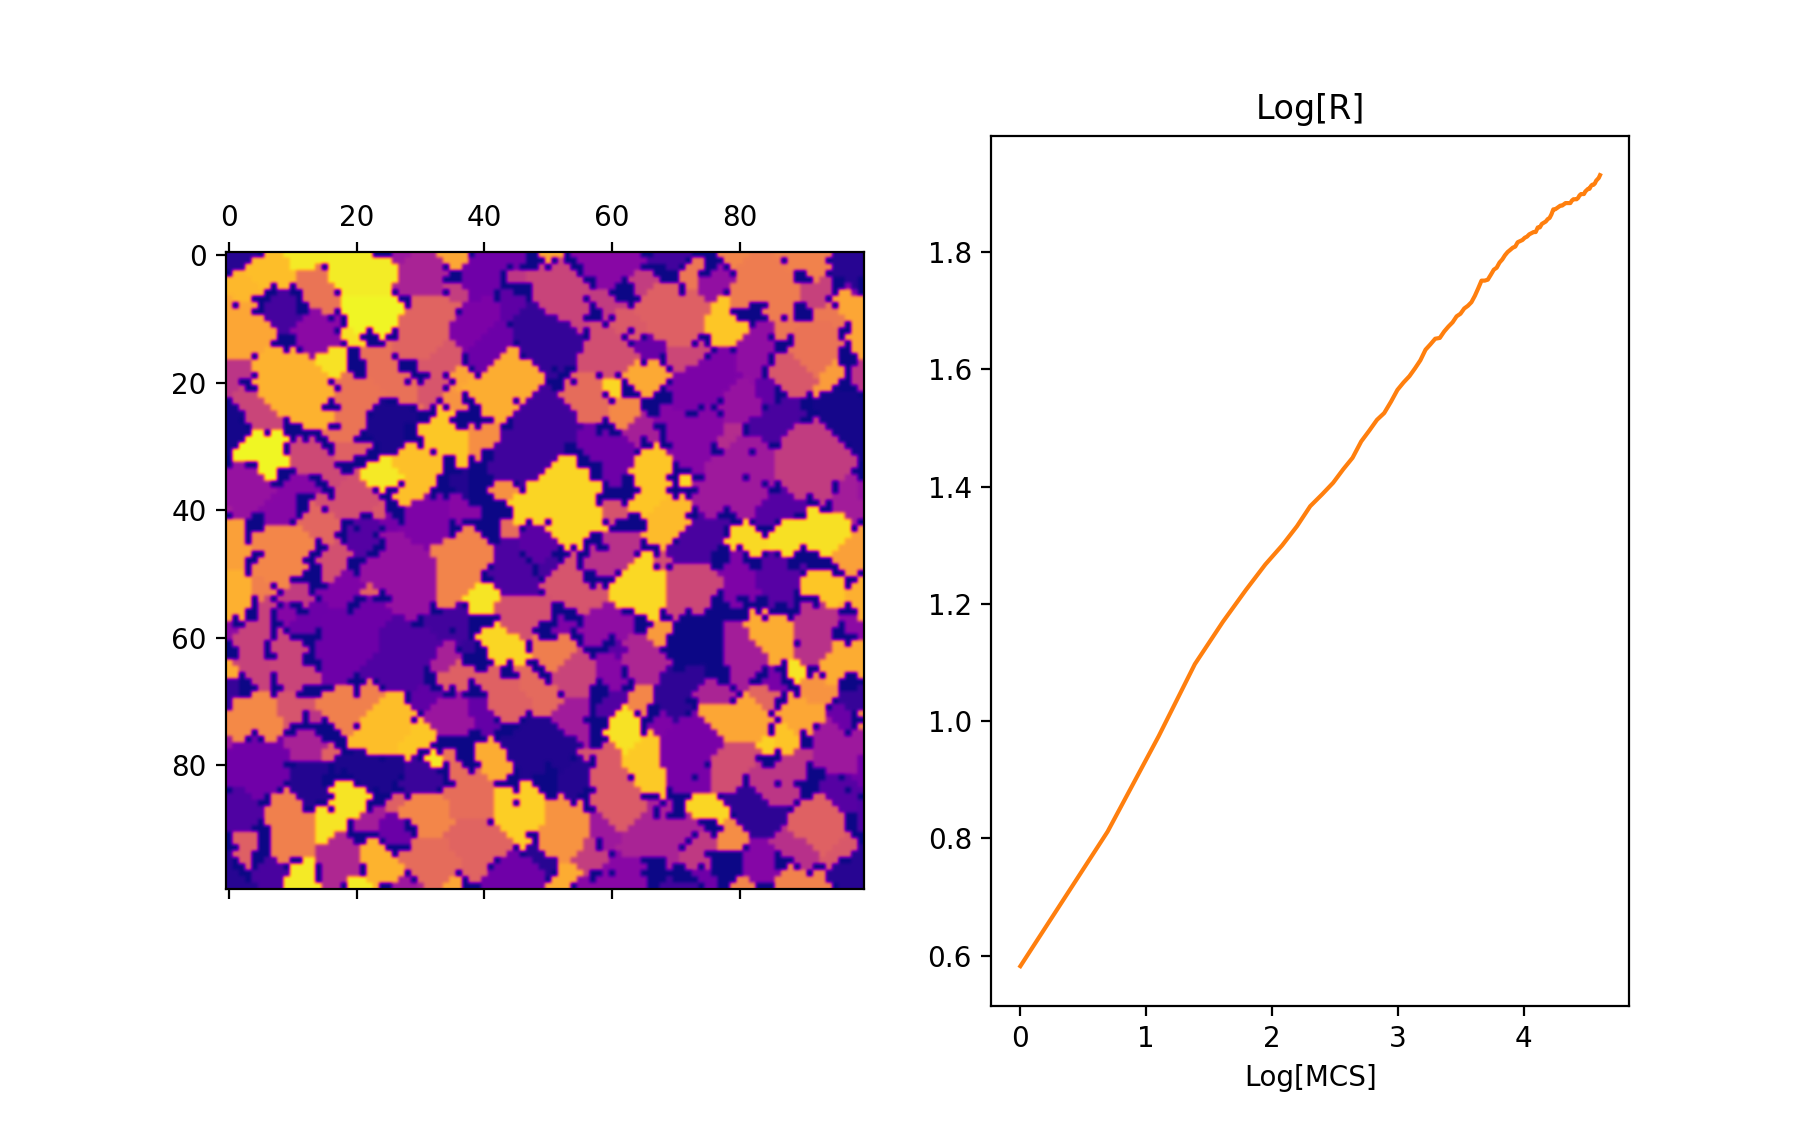

1      3123
2      1973
3      1425
4      1114
5      964
6      865
7      793
8      743
9      696
10      650
11      624
12      600
13      573
14      551
15      521
16      502
17      484
18      473
19      455
20      437
21      426
22      417
23      406
24      395
25      381
26      374
27      367
28      366
29      358
30      352
31      347
32      340
33      337
34      331
35      328
36      324
37      317
38      309
39      301
40      301
41      300
42      295
43      290
44      288
45      283
46      280
47      276
48      273
49      271
50      269
51      268
52      264
53      263
54      262
55      260
56      259
57      257
58      256
59      255
60      255
61      251
62      251
63      248
64      247
65      246
66      244
67      243
68      240
69      236
70      236
71      235
72      234
73      233
74      233
75      232
76      231
77      231
78      231
79      231
80      229
81      228
82      228
83      228
84      2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.optimize as opt
from numba import njit
%matplotlib notebook

def largest_primes_under(N):
    n = N - 1
    while n >= 2:
        if all(n % d for d in range(2, int(n ** 0.5 + 1))):
            return n
        n -= 1

@njit
def Neighbors(Lattice,i,j,n=1):
    ''' Returns an flat array of all neighboring sites in the n-th coordination sphere including the center'''
    N, M = Lattice.shape
    rows = np.array([(i-1) % N, i, (i+1) % N])
    cols = np.array([(j-1) % N, j, (j+1) % M])
    return Lattice[rows,:][:,cols].flatten()

@njit
def calc_dE(Lattice, x, y, z):
    N, M = Lattice.shape
    old_energy = 0
    new_energy = 0
    for i in [0,1,-1]:
        for j in [0,1,-1]:
            if i == 0 and j == 0:
                continue
            if Lattice[(x+i)%N,(y+j)%M] == 0:
                continue
            if Lattice[x%N,y%M] == Lattice[(x+i)%N,(y+j)%M]:
                old_energy += 1
            elif z == Lattice[(x+i)%N,(y+j)%M]:
                new_energy += 1
    return old_energy-new_energy

@njit
def inject_defects(Lattice):
    N, M = Lattice.shape
    for t in range(1,defect+1):
        index = np.random.randint(N*M)
        x = index % N
        y = index // N
        Lattice[x%N,y%N] = 0
    return Lattice
            
    
N, M = 100,100
f_defect = 0.05
orientations = N*M
defects = np.rint(orientations*f_defect)
defect = defects.astype(int)

beta = 2.5
MCS = int(100)

a = largest_primes_under(N*M)
P = np.random.randint(1,orientations+1,size=(N,M))
L = inject_defects(P)

ims=[]
logt_all=[]
logr_all=[]

fig, axs = plt.subplots(nrows=1, ncols=2)
mat = axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser')
mvt = axs[1].plot(logt_all,logr_all)
axs[1].set(title='Log[R]', xlabel='Log[MCS]')

for t in range(1,MCS+1):
    rand = np.random.randint(N*M)
    for i in range(0,N**2):
        index = (a*i + rand) % (N**2)
        x = index % N
        y = index // N
        if L[x,y] != 0:
            n = Neighbors(L,x,y)
            if len(n)-1 == 0:
                continue
            else:
                z = np.random.choice(n)
            dE = calc_dE(L,x,y,z)
            if  (dE < 0):
                L[x%N,y%N] = z
            elif np.random.sample() < np.exp(-dE*beta):
                L[x%N,y%N] = z
    
    ims.append((axs[0].matshow(L,animated=True,cmap = plt.get_cmap('plasma', orientations+1), vmin = -0.5, vmax = orientations+0.5, interpolation='kaiser'),))

    logt_all.append(np.log(t))                            # store log(MCS)
    logr_all.append(0.5*np.log(N*M/len(np.unique(L))))    # store log(grain size)
    print(t,"    ",len(np.unique(L)))                     # outputs the unique number of grains at each MCS

ani = animation.ArtistAnimation(fig,ims,interval=100,blit=True)   # Disaply animation of microstructure
lines = axs[1].plot(logt_all,logr_all)     # Plot Log[MCS] vs Log[Grain Size]
m, c = np.polyfit(logt_all,logr_all,1)     # Fit straight line to determine gradient (m) and intercept (c)
axs[1].annotate('gradient = (%.1f)'%(m),(0,0))

print('Gradient: ',m,'  Intercept: ',c)

fig.show()

